In [23]:
# Python + PySpark
from pyspark.sql import SparkSession
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("BankFinancialProject").getOrCreate()

# Load CSVs into Spark DataFrames
customers = spark.read.csv("C:/Users/cscsu/Downloads/Bank Sample Data/customers.csv", header=True, inferSchema=True)
loans = spark.read.csv("C:/Users/cscsu/Downloads/Bank Sample Data/loans.csv", header=True, inferSchema=True)
transactions = spark.read.csv("C:/Users/cscsu/Downloads/Bank Sample Data/transactions.csv", header=True, inferSchema=True)

# Show sample
customers.show(5)
loans.show(5)
transactions.show(5)


+----------+------------+---+------+----------+------+-------------+
|CustomerID|        Name|Age|Gender|Occupation|Income|MaritalStatus|
+----------+------------+---+------+----------+------+-------------+
|      C001|Amanda Huber| 65|  Male|    Doctor|186178|      Married|
|      C002|Joshua Woods| 35|  Male|   Manager|120302|      Married|
|      C003| Emily Clark| 30|Female|  Engineer|198887|      Married|
|      C004|  Misty Clay| 61|  Male|    Lawyer|170548|       Single|
|      C005|   Joy House| 25|Female|  Engineer| 74552|      Married|
+----------+------------+---+------+----------+------+-------------+
only showing top 5 rows

+------+----------+----------+--------+------------+------------+----------+
|LoanID|CustomerID|LoanAmount|LoanType|InterestRate|TenureMonths|LoanStatus|
+------+----------+----------+--------+------------+------------+----------+
|  L001|      C036|    968315|Business|       11.27|          60|   Default|
|  L002|      C024|    280553|Personal|       

In [25]:
# Drop nulls
customers = customers.dropna()
loans = loans.dropna()
transactions = transactions.dropna()

# Convert columns to proper types
from pyspark.sql.functions import col
loans = loans.withColumn("LoanAmount", col("LoanAmount").cast("float")) \
             .withColumn("InterestRate", col("InterestRate").cast("float")) \
             .withColumn("TenureMonths", col("TenureMonths").cast("int"))

transactions = transactions.withColumn("Amount", col("Amount").cast("float"))


In [33]:
from pyspark.sql.functions import sum as _sum, avg, count

# Loan summary: aggregate per customer
loan_summary = loans.groupBy("CustomerID") \
    .agg(
        _sum("LoanAmount").alias("TotalLoan"),
        avg("InterestRate").alias("AvgInterest"),
        count("LoanID").alias("LoanCount")
    )

# Transaction summary
transaction_summary = transactions.groupBy("CustomerID") \
    .agg(
        _sum("Amount").alias("TotalTransaction"),
        count("TransactionID").alias("TransactionCount")
    )

# Merge with customers
customer_financials = customers \
    .join(loan_summary, on="CustomerID", how="left") \
    .join(transaction_summary, on="CustomerID", how="left")

customer_financials.printSchema()
customer_financials.show(5)  # Check column names



root
 |-- CustomerID: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- TotalLoan: double (nullable = true)
 |-- AvgInterest: double (nullable = true)
 |-- LoanCount: long (nullable = true)
 |-- TotalTransaction: double (nullable = true)
 |-- TransactionCount: long (nullable = true)

+----------+------------+---+------+----------+------+-------------+---------+------------------+---------+----------------+----------------+
|CustomerID|        Name|Age|Gender|Occupation|Income|MaritalStatus|TotalLoan|       AvgInterest|LoanCount|TotalTransaction|TransactionCount|
+----------+------------+---+------+----------+------+-------------+---------+------------------+---------+----------------+----------------+
|      C001|Amanda Huber| 65|  Male|    Doctor|186178|      Married| 6598

In [17]:
# Join all data
# customer_financials = customers.join(loan_summary, on="CustomerID", how="left") \
#                                .join(transaction_summary, on="CustomerID", how="left")
# customer_financials.show()


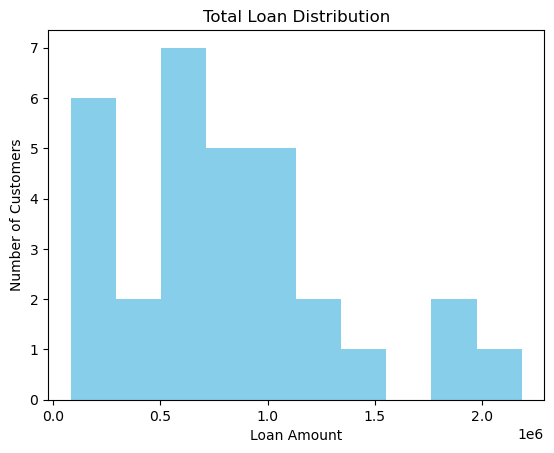

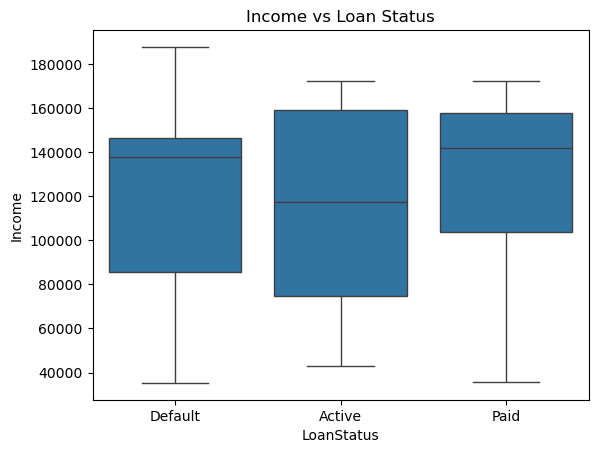

+----------+------+----------+---------+------------+------------+----------+------------------+---+------+-----------+------+-------------+---------+------------------+---------+----------------+----------------+
|CustomerID|LoanID|LoanAmount| LoanType|InterestRate|TenureMonths|LoanStatus|              Name|Age|Gender| Occupation|Income|MaritalStatus|TotalLoan|       AvgInterest|LoanCount|TotalTransaction|TransactionCount|
+----------+------+----------+---------+------------+------------+----------+------------------+---+------+-----------+------+-------------+---------+------------------+---------+----------------+----------------+
|      C001|  L036|  264102.0| Personal|       12.31|          48|   Default|      Amanda Huber| 65|  Male|     Doctor|186178|      Married| 659843.0|11.325000286102295|        2|            NULL|            NULL|
|      C001|  L033|  395741.0|     Home|       10.34|          36|   Default|      Amanda Huber| 65|  Male|     Doctor|186178|      Married| 659

In [41]:
import matplotlib.pyplot as plt

# Convert to pandas for visualization
pdf = customer_financials.toPandas()

# Loan amount distribution
plt.hist(pdf['TotalLoan'].dropna(), bins=10, color='skyblue')
plt.title("Total Loan Distribution")
plt.xlabel("Loan Amount")
plt.ylabel("Number of Customers")
plt.show()

# Loan Status vs Income
import seaborn as sns
loan_merged = loans.join(customer_financials, on="CustomerID")
sns.boxplot(x='LoanStatus', y='Income', data=loan_merged.toPandas())
plt.title("Income vs Loan Status")
plt.show()
loan_merged.show()


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Prepare dataset
loan_df = loan_merged.toPandas()
loan_df['LoanStatusBinary'] = loan_df['LoanStatus'].apply(lambda x: 1 if x=='Default' else 0)

features = ['Income','Age','TotalLoan','LoanCount']
X = loan_df[features].fillna(0)
y = loan_df['LoanStatusBinary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10

[[4 1]
 [2 3]]
